**Scene:**

Its 3pm and your supervisor has just handed you their old Fortran77 code that they swear "solved this problem in the 80s" and "is really smartly written and easy to follow". After the meeting you take one look at the code and realize it doesn't. And it's not. 

But, you said you'd have results by the group meeting the following day, so lets see if we can understand what it is doing, fix it up, and get some results!

$_{\rm Also,\ this\ code\ has\ somehow\ already\ been\ converted\ into\ python\ 3.\ who\ knows}$






**In this question we will try to develop some smart coding practices, and try to improve upon some poorly written code.**

You are provided with the following code in this workbook, 
which is both memory and computationally inefficient (and poorly commented)

Your task is to speed the code up as much as possible, and to make it as memory efficient as possible.
Also, you should comment "important" lines with what operations they seem to be performing

Hints:

**1.) Try to get rid of every single for loop (vectorize everything you can)**

**2.) Get rid of duplicate memory allocation**

> e.g. 

> array1 = np.zeros((10,10))

> array2 = array1 * 2.0

> array3 = array2**2 

> Instead just use array1 = array1 * 2.0 ; array1 = array1**2, etc.


**Marks will be based on:**

1.) run time of your improved code compared to the original (0 for loops are needed)

2.) memory usage of your code compared to the original

3.) Documentation. Fix missing comments (hint: look for lines that start with "###"), and feel free to add additional ones if you feel they are necessary

**Lets first test some good coding practices here:**

1.) **Never use for loops unless you have to - super slow! Vectorize everything**

e.g.:

In [2]:
# Make random data arrays

import numpy as np
import time

N = 10000000
A = np.arange(N)
B = np.random.uniform(size=N)

print("data created")

# test time to use for loop vs vectorized version

# Bad Way
start = time.time()
total = 0
for i in range(N):
    total += A[i] * B[i]
end = time.time()
print("For loop: total = %d in time = %d seconds"%(total, end-start))

# Good Way
start = time.time()
total = np.sum(A*B)
end = time.time()
print("Vectorized: total = %d in time = %d seconds"%(total, end-start))


data created
For loop: total = 24996531096970 in time = 168 seconds
Vectorized: total = 24996531096970 in time = 0 seconds


2.) **Don't convert lists to arrays/array to lists unless necessary for some reason**

e.g.:


In [2]:
N = 10000000

# Bad Way
start = time.time()
A = []
for i in range(N):
    A_i = np.random.uniform()
    A.append(A_i)

A = np.array(A)
end = time.time()
print("List/For loop: total = %d in time = %d seconds"%(total, end-start))


# Good Way
start = time.time()
A = np.random.uniform(size=N)
end = time.time()
print("Array Vectorized: total = %d in time = %d seconds"%(total, end-start))


List/For loop: total = 25006489979015 in time = 54 seconds
Array Vectorized: total = 25006489979015 in time = 1 seconds


3.) **Don't duplicate arrays unless you actually need the multiple versions**

e.g.:

In [3]:
A = np.random.uniform(size=(100,100))
B = A*2
C = B**2

# you've now tripled the memory usage to calculate C from A. Unless you actually need A and B later, don't do this. 
# Just do:
A = np.random.uniform(size=(100,100))
A = A*2
A = A**2

# or 

A = np.random.uniform(size=(100,100))
A *= 2
A = A**2

# or whatever

**Code Outline**
The code you will be working with is a mockup of a three dimensional "large scale structure survey", or a "mock" observation. Using this code we want to populate our field of view with the flux from a number (Nhalo) of dark matter halos. 

Each of these halos will be given:

1.) a randomly drawn position in (ra [deg], dec [deg], distance [Mpc (comoving)])

2.) a randomly drawn Mass in [Msun], drawn from an analytical Halo Mass Function (HMF) 


For each of these halos you will calculate a Luminosity, based on the given Mass-to-Luminosity relation mass_to_luminosity(mass). 

You will then bin the luminosity of these halos into a three dimensional map/array of size (npix_x, npix_y, npix_z) which represents (ra, dec, distance - aka a three dimensional data cube, where each voxel (3D pixel) represents the luminosity coming from that region of space.)

You will then perform a simple "analysis" of this map 

**first, a bit on what a "dark matter halo mass function" is:**

The Halo Mass function describes the number of dark matter halos of a given mass M

For this example we will use a simplified version of the form HMF = M * np.exp(-M/Mstar), where M is the mass of a halo

How do we randomly draw halo mass values according to a distribution? **This is a very common type of excercise for reserch/job interviews.**

Probability distrution function PDF: 

$f(x)= A x exp(-x/b)$

where $A = \int_0^{inf} f(x) dx$

and b is given

Cumlative distribution function CDF: 

$ F(x) = \int_0^x f(x)dx $

so

$F(x) = Ab(b-(x+b)exp(-x/b))$

Cannot invert this analytically, so must do numerically.

With the inverted CDF, CDFinv, we can simply draw a uniform random number in the range (0,1), plug this into the CDFinv, and it will return samples drawn from any PDF that we desire!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy import interpolate
import time

tstart = time.time()

# Halo Parameters
#Nhalo = 1000000 # set to 100000000 for final run (Note large numbers will probably not even work with the original poorly written code)
Nhalo = 1000000000
# Map parameters
#npix_x = 100 # set to 1000 for final run
#npix_y = 100 # set to 1000 for final run
#npix_z = 100 # set to 1000 for final run
#
npix_x = 1000
npix_y = 1000
npix_z = 1000

fov_x = 10 # in degrees
fov_y = 10 # in degrees
chi_min = 0. # minimum distance
chi_max = 3.e3 # maximum distance

###
dx_pix = fov_x/npix_x
dy_pix = fov_y/npix_y
dz_pix = (chi_max - chi_min)/npix_z

# create empty lists 
ra_list   = [] # right ascention
dec_list  = [] # declination
chi_list  = [] # distance

#set seed, so the random draw always returns the same set of numbers
np.random.seed(13579)

####
#for i in range(Nhalo):
#    rand_ra = np.random.uniform(-fov_x/2, fov_x/2)
#    ra_list.append(rand_ra)
#
#for i in range(Nhalo):
#    rand_dec = np.random.uniform(-fov_y/2, fov_y/2)
#    dec_list.append(rand_dec)
#    
#for i in range(Nhalo):
#    rand_chi = np.random.uniform(chi_min, chi_max)
#    chi_list.append(rand_chi)
#   
# convert lists to numpy arrays to perform calculations
#ra  = np.array(ra_list)
#dec = np.array(dec_list)
#chi = np.array(chi_list)

ra = np.random.uniform(-fov_x/2, fov_x/2, Nhalo)
dec = np.random.uniform(-fov_y/2, fov_y/2, Nhalo)
chi = np.random.uniform(chi_min, chi_max, Nhalo)


### 

# Set max and Min mass so integral converges
Mmin  = 0.
Mmax  = 1.e16
Mstar = 1.e13

###
hmf_func = lambda M: M*np.exp(-M/Mstar)
norm_pdf, err = integrate.quad(hmf_func, Mmin, Mmax)

hmf_pdf = lambda x: 1./norm_pdf * x*np.exp(-x/Mstar)

###
hmf_cdf = lambda x: 1./norm_pdf * Mstar * (Mstar - (x + Mstar)*np.exp(-x/Mstar))

# Make array of masses
M = np.linspace(Mmin, Mmax, 10000)

# Get CDF value at each M
CDF_of_M = hmf_cdf(M)

### 
CDF_of_M_inv = interpolate.interp1d(CDF_of_M, M)

## Does drawing from this give the correct mass function?? Check 
#
#mass_list = []
#
####
#for i in range(Nhalo):
#    rand_num_i  = np.random.uniform()
#    rand_mass_i = CDF_of_M_inv(rand_num_i)
#    mass_list.append(rand_mass_i)
#
mass = CDF_of_M_inv(np.random.uniform(size=Nhalo))

####
mass_to_luminosity = lambda x: (x/Mstar)**2.4 
#
#Lum_list = []
#for i in range(len(mass)):
#    Lum_i = mass_to_luminosity(mass[i])
#    Lum_list.append(Lum_i)
#
#Lum = np.array(Lum_list)
#Lum = mass_to_luminosity(mass)

#Flux_list = []
#for i in range(Nhalo):
#    Flux_i = Lum[i]/4/np.pi/chi[i]**2
#    Flux_list.append(Flux_i)
#
#Flux = np.array(Flux_list)
#Flux = Lum/4/np.pi/chi**2
#Flux = mass_to_luminosity(mass)/4/np.pi/chi**2

#### 
#map_1 = np.zeros((npix_x,npix_y,npix_z))
#for h in range(Nhalo):
#    ra_h  = ra[h]
#    dec_h = dec[h]
#    chi_h = chi[h]
#    
#    ###
#    pix_x_i = int( (ra_h +fov_x/2) // dx_pix )
#    pix_y_i = int( (dec_h+fov_y/2) // dy_pix )
#    pix_z_i = int( (chi_h        ) // dz_pix )
#    
#    for i in range(npix_x):
#        if pix_x_i == i:
#            for j in range(npix_y):
#                if pix_y_i == j:
#                    for k in range(npix_z):
#                        if pix_z_i == k:
#                            map_1[i,j,k] = map_1[i,j,k] + Flux[h]
#map_1 = Flux.reshape(npix_x, npix_y, npix_z)
#map_1 = (mass_to_luminosity(mass)/4/np.pi/chi**2).reshape(npix_x, npix_y, npix_z)


###
chi_cut = 500
#map_sum = np.zeros((npix_x,npix_y))
#for i in range(npix_x):
#    for j in range(npix_y):
#        npix_include = 0
#        for k in range(npix_z):
#            if k*dz_pix > chi_cut:
#                map_sum[i,j] += map_1[i,j,k]
#                npix_include += 1
                
#map_mean = np.mean(map_1[:, :, int(chi_cut / dz_pix):], axis=2)
# Line below: basically, do everything and save memory. Randomly place masses in space and determine, 
# from the mass-luminosity function, the light that each object contributes. Then convert from 3d space 
# to a 2d sky. 
map_mean = np.mean(((mass_to_luminosity(mass)/4/np.pi/chi**2).reshape(npix_x, npix_y, npix_z))[:, :, int(chi_cut / dz_pix):], axis=2)
#npix_include = map_sum[2]
#map_mean = map_sum/npix_include

tend = time.time()

print("total runtime = %d seconds" % (tend-tstart))

print('done')

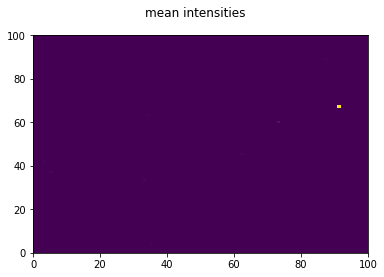

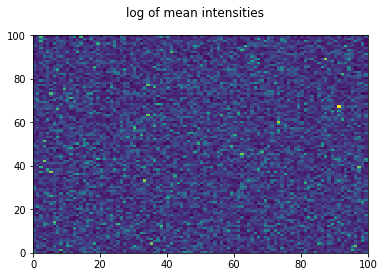

[[2.51895483e-04 3.03473412e-05 1.00756325e-05 ... 1.84075273e-06
  2.18672459e-05 1.60390764e-04]
 [6.17849681e-04 3.47043385e-06 2.78485322e-06 ... 2.27477519e-04
  9.01925591e-06 1.65930877e-05]
 [2.29261494e-06 1.60862379e-04 4.49105751e-05 ... 1.37790230e-05
  5.09573985e-06 2.40953268e-06]
 ...
 [3.07568460e-06 2.24391662e-05 5.10098359e-01 ... 3.41106099e-05
  4.03790578e-06 1.06419988e-06]
 [5.94081660e-06 2.39473112e-05 7.50872378e-04 ... 2.55851602e-04
  1.50625043e-05 1.15657605e-06]
 [1.09209862e-06 4.66109068e-05 1.33667693e+00 ... 3.78759927e-05
  3.39731282e-06 1.19175205e-04]]


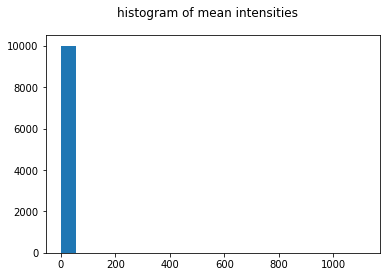

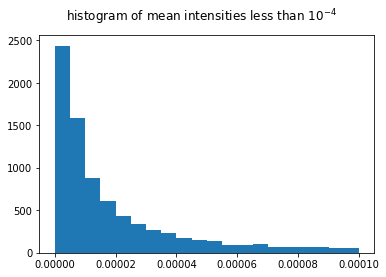

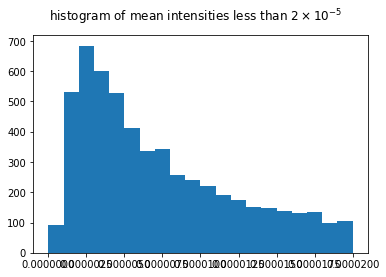

(67, 91)
(60, 73)
(37, 5)
(33, 33)
(89, 87)
(45, 62)
(63, 34)
(42, 3)
(4, 35)
(39, 97)


In [4]:
# Analyze the map "map_mean"
import matplotlib.pyplot as plt

# What does this map_mean represent? Plot it. 
# represents the average intensities of the stars in a particular direction in the sky
plt.pcolormesh(map_mean)
plt.suptitle('mean intensities')
plt.show()
plt.pcolormesh(np.log(map_mean))
plt.suptitle('log of mean intensities')
plt.show()

map_mean_flat = map_mean.flatten()
print(map_mean)
# Take the histogram of the pixel intensities. Plot that
plt.hist(map_mean_flat, bins=20, histtype='bar')
plt.suptitle('histogram of mean intensities')
plt.show()

plt.hist(map_mean_flat, bins=20, histtype='bar', range=(0, 1e-4))
plt.suptitle('histogram of mean intensities less than $10^{-4}$')
plt.show()

plt.hist(map_mean_flat, bins=20, histtype='bar', range=(0, 2e-5))
plt.suptitle('histogram of mean intensities less than $2 \\times 10^{-5}$')
plt.show()


# find the indices of the 10 brightest pixels. Print those out
# let's make a copy of the data so we can cannibalise it freely
map_mean_cp = map_mean.copy()
for i in range(10):
    indices = np.unravel_index(np.argmax(map_mean_cp), map_mean_cp.shape)
    map_mean_cp[indices] = -1. 
    print(indices)